In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from modeling_functions import evaluate_model, plot_features_importance

df = pd.read_parquet('data/2023/do_modelu.parquet')
df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()

In [18]:
X = df[[
    'Godzinowe zuzycie gd MWh',
    # 'Delta godzinowe zużycie gd MWh',
    'Godzinowe zuzycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    # 'Święto',
    'Dzień tygodnia',
    'Godzina',
    # 'Miesiąc'
]]

y = df['Cena PLN/MWh']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 2.1 Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Random Forest", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Random Forest,True,0.814623,59.157168,77.876778


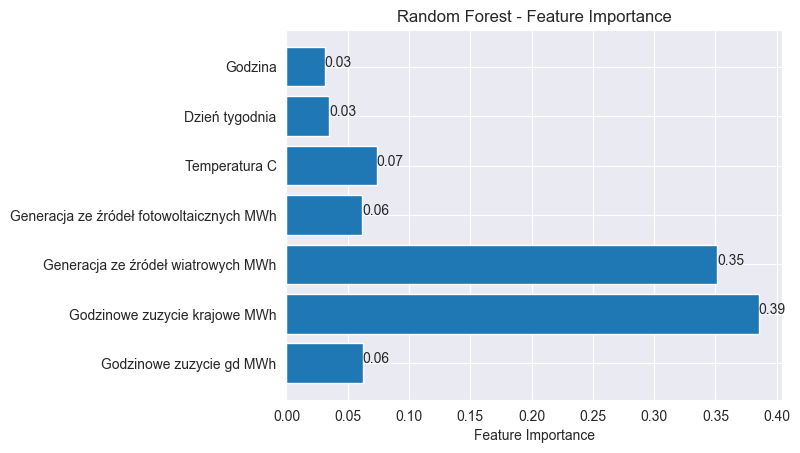

In [20]:
feature_importance = rf.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Random Forest')

## 2.2 Support Vector Machine (SVM)

### Strojenie hiperparametrów

In [8]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    # 'svr__C': [
    #     1, 10, 50, 100, 200,
    #     500, 1000, 2000, 5000
    # ],
    'svr__C': [
         800, 
    ],
    'svr__gamma': [0.1, 1, 2, 3, 'scale'],
}
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)


Best parameters: {'svr__C': 800, 'svr__gamma': 1}


### Cross validation

Cross-validation R^2 scores: [0.82566522 0.82897855 0.82728216 0.82272212 0.81921437]
Mean R^2 score: 0.824772485079917
Standard deviation of R^2 scores: 0.003460722188736919


In [17]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))
# svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=150, gamma=1))
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Support Vector Machine", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Random Forest,True,0.814623,59.157168,77.876778
0,Support Vector Machine,True,0.830456,52.181312,74.476787


## 2.3 Gradient Boosting Machines (GBM)

In [18]:
from xgboost import XGBRegressor

gbm = XGBRegressor(random_state=42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Gradient Boosting Machines", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Random Forest,True,0.814623,59.157168,77.876778
0,Support Vector Machine,True,0.830456,52.181312,74.476787
0,Gradient Boosting Machines,True,0.800886,61.579017,80.710705


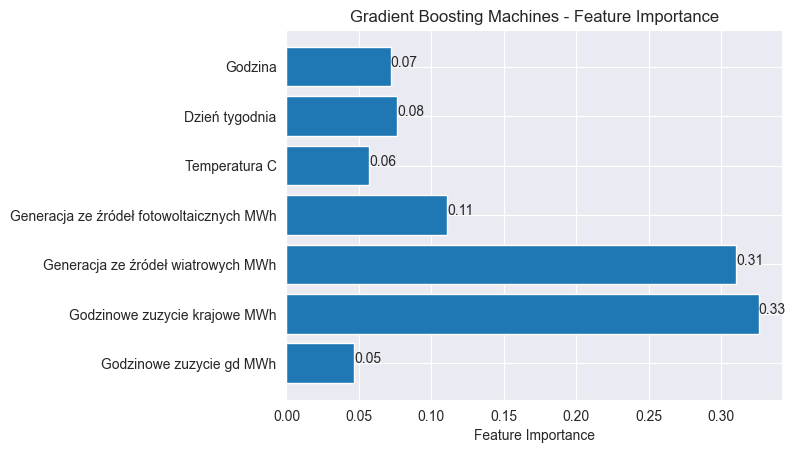

In [10]:
feature_importance = gbm.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Gradient Boosting Machines')


# Final training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from modeling_functions import evaluate_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


df = pd.read_parquet('data/2023/do_modelu.parquet')
# df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()


def create_model_random_forest(X_train, y_train):
    # Initialize and train Random Forest models
    rf = RandomForestRegressor(random_state=42)
    # Fit data
    rf.fit(X_train, y_train)

    return rf

def create_model_svm(X_train, y_train):
    # Standardize features and train SVM
    svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))
    # Fit data
    svr.fit(X_train, y_train)

    return svr

def create_model_gbm(X_train, y_train):
    # Initialize and train Gradient Boosting model
    gbm = XGBRegressor(random_state=42)
    # Fit data
    gbm.fit(X_train, y_train)
    
    return gbm

def train_models_and_compare(df: pd.DataFrame, X_columns: list, with_gd: bool):
    X = df[X_columns].copy()
    y = df['Cena PLN/MWh']
    
    df_evaluate = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    rf_model = create_model_random_forest(X_train, y_train)
    svm_model = create_model_svm(X_train, y_train)
    gbm_model = create_model_gbm(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_gbm = gbm_model.predict(X_test)

    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_rf, "Random Forest", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_svm, "Support Vector Machine", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_gbm, "Gradient Boosting Machines", with_gd)
    
    ### Szkolenie na całym zbiorze, tylko do porównania metryk 
    # y_pred_rf = rf_model.predict(X)
    # y_pred_svm = svm_model.predict(X)
    # y_pred_gbm = gbm_model.predict(X)
    # 
    # df_evaluate = evaluate_model(df_evaluate, y, y_pred_rf, "Random Forest", with_gd)
    # df_evaluate = evaluate_model(df_evaluate, y, y_pred_svm, "Support Vector Machine", with_gd)
    # df_evaluate = evaluate_model(df_evaluate, y, y_pred_gbm, "Gradient Boosting Machines", with_gd)
    
    return df_evaluate

In [2]:
X_gd_columns = [
    'Godzinowe zuzycie gd MWh',
    'Godzinowe zuzycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Dzień tygodnia',
    'Godzina',
]

X_no_gd_columns = [
    'Godzinowe zuzycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Dzień tygodnia',
    'Godzina',
]

df_evaluate_no_gd = train_models_and_compare(df, X_no_gd_columns, with_gd=False)
df_evaluate_with_gd = train_models_and_compare(df, X_gd_columns, with_gd=True)


In [3]:
df_result = pd.concat([df_evaluate_no_gd, df_evaluate_with_gd]).reset_index(drop=True).sort_values('Model')
df_result

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
2,Gradient Boosting Machines,False,0.789769,63.857318,82.933137
5,Gradient Boosting Machines,True,0.800886,61.579017,80.710705
0,Random Forest,False,0.807385,60.399507,79.382662
3,Random Forest,True,0.814623,59.157168,77.876778
1,Support Vector Machine,False,0.810530,55.244262,78.731917
4,Support Vector Machine,True,0.830456,52.181312,74.476787


### Walidacja krzyżowa najlepszego modelu

In [6]:
from sklearn.model_selection import cross_val_score

y = df['Cena PLN/MWh']
X = df[X_gd_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


best_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Display cross-validation results
print("Cross-validation R^2 scores:", cv_scores)
print("Mean R^2 score:", cv_scores.mean())
print("Standard deviation of R^2 scores:", cv_scores.std())

Cross-validation R^2 scores: [0.82566522 0.82897855 0.82728216 0.82272212 0.81921437]
Mean R^2 score: 0.824772485079917
Standard deviation of R^2 scores: 0.003460722188736919


## Wizualizacja najlepszego modelu

In [26]:
y = df['Cena PLN/MWh']

X_gd = df[X_gd_columns].copy()
X_train, X_test, y_train, y_test = train_test_split(X_gd, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
svm_model = create_model_svm(X_train, y_train)
price_predicted = svm_model.predict(X_gd)
df['Cena prognozowana z gd PLN/MWh'] = price_predicted

X_no_gd = df[X_no_gd_columns].copy()
X_train, X_test, y_train, y_test = train_test_split(X_no_gd, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
svm_model = create_model_svm(X_train, y_train)
price_predicted = svm_model.predict(X_no_gd)
df['Cena prognozowana bez gd PLN/MWh'] = price_predicted


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df is already defined with the required columns
# Plotting a line chart with three different 'Cena' columns

def plot_scores(df):
    plt.figure(figsize=(12, 6))
    linewidth = 2.5
    alpha = 0.6
    plt.plot(df.index, df['Cena PLN/MWh'], label='Cena PLN/MWh', linewidth=linewidth, alpha=alpha)
    plt.plot(df.index, df['Cena prognozowana z gd PLN/MWh'], label='Cena prognozowana z gd PLN/MWh', linewidth=linewidth, alpha=alpha)
    plt.plot(df.index, df['Cena prognozowana bez gd PLN/MWh'], label='Cena prognozowana bez gd PLN/MWh', linewidth=linewidth, alpha=alpha)
    
    # Adding labels and title
    plt.xlabel('Data')
    plt.ylabel('Cena (PLN/MWh)')
    plt.title('Comparison of Different Cena Columns')
    plt.legend()
    plt.grid(True)
    
    plt.show()


### MAE, RSME dla całego zbioru danych (pogrupowanego po dniach)

In [28]:
import numpy as np

df['Dzień'] = df['Data Godzina'].dt.day
df['Rok'] = df['Data Godzina'].dt.year
df['MAE gd'] = abs(df['Cena PLN/MWh'] - df['Cena prognozowana z gd PLN/MWh'])
df['MAE bez gd'] = abs(df['Cena PLN/MWh'] - df['Cena prognozowana bez gd PLN/MWh'])

df['MSE gd'] = (df['Cena PLN/MWh'] - df['Cena prognozowana z gd PLN/MWh']) ** 2
df['MSE bez gd'] = (df['Cena PLN/MWh'] - df['Cena prognozowana bez gd PLN/MWh']) ** 2


In [30]:
df_group = df.groupby(['Dzień', 'Miesiąc']).agg({
    'Data Godzina': 'min',
    'MAE gd': 'mean',
    'MAE bez gd': 'mean',
    'MSE gd': 'mean',
    'MSE bez gd': 'mean'
}).reset_index()

# df_group = df.groupby(['Rok']).mean().reset_index()
df_group['RMSE gd'] = np.sqrt(df_group['MSE gd'])
df_group['RMSE bez gd'] = np.sqrt(df_group['MSE bez gd'])
df_group['RMSE porównanie'] = (df_group['RMSE bez gd'] / df_group['RMSE gd'])
df_group

,Dzień,Miesiąc,Data Godzina,MAE gd,MAE bez gd,MSE gd,MSE bez gd,RMSE gd,RMSE bez gd,RMSE porównanie
0,1,1,2023-01-01 00:00:00+01:00,13.570128,82.909705,1242.679422,18247.356135,35.251658,135.082775,3.831955
1,1,2,2023-02-01 00:00:00+01:00,17.535384,25.224372,659.681064,1217.208347,25.684257,34.888513,1.358362
2,1,3,2023-03-01 00:00:00+01:00,17.678745,28.747421,722.665687,1714.336662,26.882442,41.404549,1.540208
3,1,4,2023-04-01 00:00:00+02:00,14.875006,20.853422,420.942141,856.989504,20.516875,29.274383,1.426844
4,1,5,2023-05-01 00:00:00+02:00,47.906409,42.346434,5572.588177,4570.812560,74.649770,67.607785,0.905666
...,...,...,...,...,...,...,...,...,...,...
360,31,5,2023-05-31 00:00:00+02:00,16.732172,19.166864,834.763639,951.222267,28.892276,30.841891,1.067479
361,31,7,2023-07-31 00:00:00+02:00,10.908028,22.057084,311.958569,936.413200,17.662349,30.600869,1.732548
362,31,8,2023-08-31 00:00:00+02:00,10.820802,16.274132,321.259624,499.280715,17.923717,22.344590,1.246649
363,31,10,2023-10-31 00:00:00+01:00,23.225669,31.057318,1427.885711,1913.483141,37.787375,43.743378,1.157619


In [32]:
df_group

,Dzień,Miesiąc,Data Godzina,MAE gd,MAE bez gd,MSE gd,MSE bez gd,RMSE gd,RMSE bez gd,RMSE porównanie
0,1,1,2023-01-01 00:00:00+01:00,13.570128,82.909705,1242.679422,18247.356135,35.251658,135.082775,3.831955
1,1,2,2023-02-01 00:00:00+01:00,17.535384,25.224372,659.681064,1217.208347,25.684257,34.888513,1.358362
2,1,3,2023-03-01 00:00:00+01:00,17.678745,28.747421,722.665687,1714.336662,26.882442,41.404549,1.540208
3,1,4,2023-04-01 00:00:00+02:00,14.875006,20.853422,420.942141,856.989504,20.516875,29.274383,1.426844
4,1,5,2023-05-01 00:00:00+02:00,47.906409,42.346434,5572.588177,4570.812560,74.649770,67.607785,0.905666
...,...,...,...,...,...,...,...,...,...,...
360,31,5,2023-05-31 00:00:00+02:00,16.732172,19.166864,834.763639,951.222267,28.892276,30.841891,1.067479
361,31,7,2023-07-31 00:00:00+02:00,10.908028,22.057084,311.958569,936.413200,17.662349,30.600869,1.732548
362,31,8,2023-08-31 00:00:00+02:00,10.820802,16.274132,321.259624,499.280715,17.923717,22.344590,1.246649
363,31,10,2023-10-31 00:00:00+01:00,23.225669,31.057318,1427.885711,1913.483141,37.787375,43.743378,1.157619


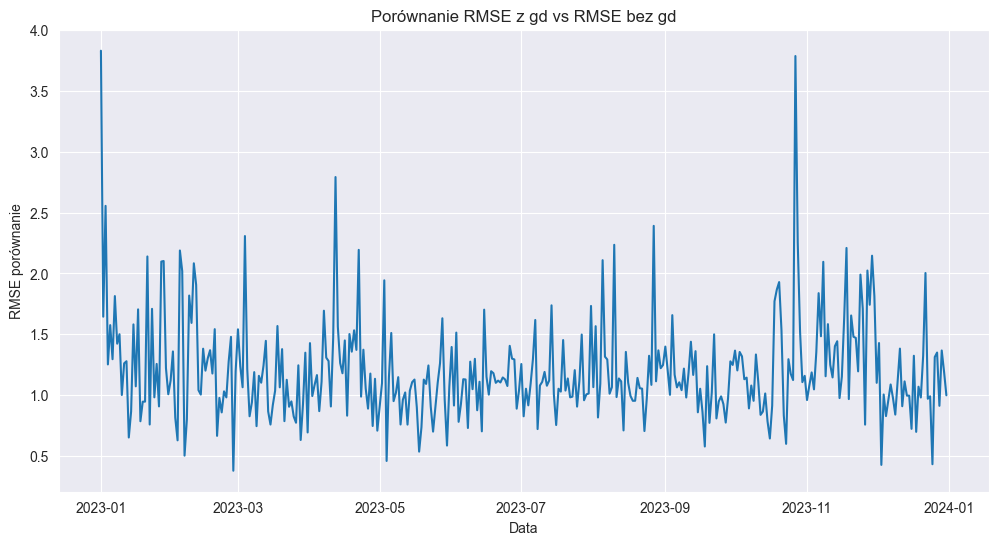

In [38]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_group['Data Godzina'].dt.date, y=df_group['RMSE porównanie'])

plt.xlabel('Data')
plt.title('Porównanie RMSE z gd vs RMSE bez gd')
plt.grid(True)

plt.show()

In [15]:
df_group

,Dzień,Miesiąc,Data Godzina,Delta godzinowe zużycie gd MWh,Godzinowe zuzycie gd MWh,Godzinowe zuzycie krajowe MWh,Generacja ze źródeł wiatrowych MWh,Generacja ze źródeł fotowoltaicznych MWh,Cena PLN/MWh,Temperatura C,...,Cena prognozowana z gd PLN/MWh,Cena prognozowana bez gd PLN/MWh,Rok,MAE gd,MAE bez gd,MSE gd,MSE bez gd,RMSE gd,RMSE bez gd,RMSE %
0,1,1,2023-01-01 11:30:00+01:00,-34.462191,3901.970800,12462.125000,4396.791667,534.916667,210.455833,12.044536,...,217.071111,255.501528,2023.0,13.570128,82.909705,1242.679422,18247.356135,35.251658,135.082775,283.195518
1,1,2,2023-02-01 11:30:00+01:00,-39.441942,3821.134642,20302.333333,6938.833333,271.625000,486.310417,2.379918,...,497.770289,489.532003,2023.0,17.535384,25.224372,659.681064,1217.208347,25.684257,34.888513,35.836178
2,1,3,2023-03-01 11:30:00+01:00,-13.960707,3597.235379,18864.375000,689.250000,1776.958333,712.961250,-0.326395,...,703.125972,689.902795,2023.0,17.678745,28.747421,722.665687,1714.336662,26.882442,41.404549,54.020787
3,1,4,2023-04-01 11:30:00+02:00,171.246630,3589.727233,15722.416667,3160.958333,791.750000,566.566250,7.164891,...,556.926618,547.125197,2023.0,14.875006,20.853422,420.942141,856.989504,20.516875,29.274383,42.684418
4,1,5,2023-05-01 11:30:00+02:00,143.400467,3261.881579,11263.791667,1240.958333,3245.666667,334.070833,9.145287,...,378.367601,375.275441,2023.0,47.906409,42.346434,5572.588177,4570.812560,74.649770,67.607785,-9.433365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,31,5,2023-05-31 11:30:00+02:00,-117.949424,3000.531688,14824.916667,1031.250000,3252.208333,499.360833,15.174112,...,505.709013,507.837243,2023.0,16.732172,19.166864,834.763639,951.222267,28.892276,30.841891,6.747876
361,31,7,2023-07-31 11:30:00+02:00,43.796353,3099.832992,14560.250000,2425.375000,2161.125000,561.725000,18.019809,...,556.254069,549.442501,2023.0,10.908028,22.057084,311.958569,936.413200,17.662349,30.600869,73.254811
362,31,8,2023-08-31 11:30:00+02:00,14.709233,3004.575696,16762.041667,1565.750000,1730.750000,547.516250,15.277937,...,549.751097,554.388662,2023.0,10.820802,16.274132,321.259624,499.280715,17.923717,22.344590,24.664937
363,31,10,2023-10-31 11:30:00+01:00,238.333585,3503.626208,18274.416667,5224.125000,398.333333,427.114583,12.485792,...,431.165126,430.613909,2023.0,23.225669,31.057318,1427.885711,1913.483141,37.787375,43.743378,15.761887


In [25]:
df_holidays = df[df['Święto'] == 1].reset_index().copy()
df_evaluate_holidays = pd.DataFrame()
df_evaluate_holidays = evaluate_model(df_evaluate_holidays, df_holidays['Cena PLN/MWh'], df_holidays['Cena prognozowana z gd PLN/MWh'], 'svm', with_gd=True)
df_evaluate_holidays = evaluate_model(df_evaluate_holidays, df_holidays['Cena PLN/MWh'], df_holidays['Cena prognozowana bez gd PLN/MWh'], 'svm', with_gd=False)
df_evaluate_holidays

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,svm,True,0.967257,15.350548,35.762307
0,svm,False,0.918268,24.717675,56.501801
